# Content

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

- [Journals](#Journals)
    - [Loading data](#Loading-data)
    - [Evolution of WoS impact factor for different disciplines](#Evolution-of-WoS-impact-factor-for-different-disciplines)
    - [ Case study: Neurosciences](#Case-study:-Neurosciences)
- [Authors, Articles and Grants](#Authors,-Articles-and-Grants)
    - [Loading data for Neurosciences](#Loading-data-for-Neurosciences)
- [Fields](#Fields)

In [2]:
from IPython.display import HTML
from itertools import groupby
import collections
import itertools

import json_lines as jl
import json

import pandas as pd
from pandas.io.json import json_normalize
import pickle

import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import numpy as np

%matplotlib inline


def nonull( data ):
    '''
    nonull:
        returns data column with no null entries
    '''
    return data[ data.isnull()==False ]

- - -

# Journals

## Loading data

Journals are imported in dataframe format. Two additional dataframes are created, one with content rating information, one with general information about the journal.

- Some contentRating fields have duplicated instances of the WoS IF. (**solved**)
- A numerical journal id (*idNum*) is added to the two new dataframes.

In [4]:
data_json = []
with open('./data/journals/journals_1.jsonl', 'r') as jsonl_file:
    for line in jsonl_file:
        data_json.append(json.loads(line))

#Creating main dataframe with journals data
journals = pd.DataFrame(data_json)
idNum = np.arange(len(journals))

#Dictionary of categoryname to index
index_journals = dict(zip(journals.id, idNum))

#Filtering journals with contentRating
mask_nr = journals.contentRating.isnull()==False
#Creating new dataframe with journals content rating
journals_rating = pd.DataFrame(json_normalize(np.array(data_json)[mask_nr],
                                              record_path=['contentRating'],
                                              meta=['id'], errors = 'ignore' ))
journals_rating = journals_rating.drop_duplicates()
repeats = [len(list(group)) for key, group in groupby(journals_rating['id'])]
journals_rating['idNum'] = np.repeat(idNum[mask_nr], repeats)
mask_nrr = np.repeat(idNum[mask_nr], repeats)
mask_wos = journals_rating.author == 'impact_factor_wos'

#Filtering journals with about field
mask_ab = journals.about.isnull()==False
#Creating new dataframe with information of journals (about)
journals_about = pd.DataFrame(json_normalize(np.array(data_json)[mask_ab],
                                              record_path=['about'],
                                              meta=['id',], 
                                              record_prefix='category',
                                              meta_prefix='',
                                              sep="_", errors = 'ignore' ))
repeats = [len(list(group)) for key, group in groupby(journals_about['id'])]
journals_about['idNum'] = np.repeat(idNum[mask_ab], repeats)
mask_abr = np.repeat(idNum[mask_ab], repeats)

In [5]:
journals_rating[:13]

,author,dateCreated,ratingValue,type,id,idNum
0,snip,NaN,0.694,Rating,sg:journal.1001267,0
1,sjr,NaN,0.576,Rating,sg:journal.1001267,0
2,impact_factor_wos,2017,1.159,Rating,sg:journal.1001267,0
3,impact_factor_wos,2016,1.154,Rating,sg:journal.1001267,0
6,impact_factor_wos,2015,0.979,Rating,sg:journal.1001267,0
9,impact_factor_wos,2014,1.111,Rating,sg:journal.1001267,0
12,impact_factor_wos,2013,1.146,Rating,sg:journal.1001267,0
15,impact_factor_wos,2009,1.232,Rating,sg:journal.1001267,0
18,impact_factor_wos,2012,1.310,Rating,sg:journal.1001267,0
21,impact_factor_wos,2011,1.030,Rating,sg:journal.1001267,0


### Using impact factor as a metric of success

When choosing a suitable journal to publish my research, I, as an author, was most interested in its impact factor (often the WoS IF). As this is the case of most scientist I know of, I will therefore use it as the [metric of success of a journal](https://scholarlykitchen.sspnet.org/2014/05/15/what-researchers-value-from-publishers-canadian-survey/).

In the following histogram, I show the year of foundation for journals with content rating (at least one entry), and without it. Journals without content rating tend to be much newer as they have not collected enough data to be rated. The most recently founded journals might be potential candidates for growth strategies.

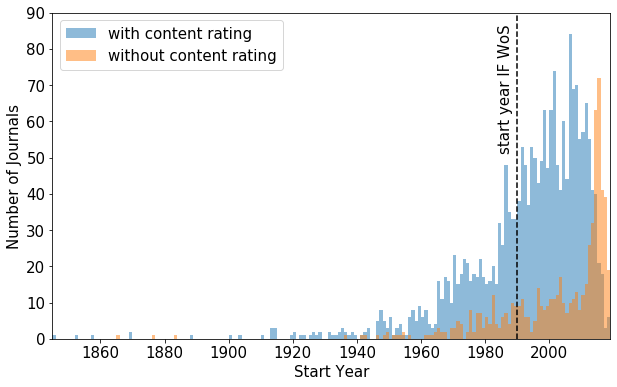

In [6]:
#Plotting start year vs count for journals with and without content rating
min_year = np.min(np.array(nonull(journals.startYear)).astype(int))
max_year = np.max(np.array(nonull(journals.startYear)).astype(int))
start_year_wos = np.min(np.array(nonull(journals_rating.dateCreated[mask_wos])).astype(int))
last_year_wos = np.max(np.array(nonull(journals_rating.dateCreated[mask_wos])).astype(int))
bins = max_year - min_year

plt.figure( figsize = (10,6) )
dm = plt.hist(np.array(nonull(journals.startYear[mask_nr])).astype(int), 
              bins=bins, range=(min_year,max_year), alpha=0.5, label='with content rating')
dm = plt.hist( np.array(nonull(journals.startYear[mask_nr==False])).astype(int), 
              bins=bins, range=(min_year,max_year), alpha=0.5, label='without content rating')

plt.xlabel( 'Start Year', fontsize = 15 )
plt.xlim( min_year, max_year )
plt.xticks( fontsize = 15 )
plt.ylabel( 'Number of Journals', fontsize = 15 )
plt.yticks( fontsize = 15 )
plt.ylim( 0, 90 )

plt.vlines( start_year_wos, 0, 90, ls='--' )
plt.text( start_year_wos-6, 52, 'start year IF WoS', fontsize=15, rotation=90 )
plt.legend( loc='upper left', fontsize = 15 )
plt.show()

## Evolution of WoS impact factor for different disciplines

A new dataframe is created for all disciplines and contains the time evolution of the median and the top 20\% WoS impact factors of the corresponding journals.

In [7]:
def IF_WoS_props( category, year=2017, percentiles=[50,80], 
                  journals_about=journals_about, journals_rating=journals_rating, complete_dist=False):
    """
    IF_WoS_props: 
        returns percentiles of WoS impact factor for a given discipline and year, number of ranked journals
        and total number of journals
    Parameters
    ----------
    category : string
    year: int
    percentiles: array_like
    journals_about: DataFrame
        Dataframe with general information of the journals.
    journals_rating: DataFrame
        Dataframe with content rating information.
    complete_dist: boolean
        Complete distribution is returned if True
    """
    mask_disc = journals_about.categoryname==category

    mask_journal_disc = np.in1d(journals_rating.idNum[mask_wos], journals_about.idNum[mask_disc])
    mask_year = journals_rating.dateCreated[mask_wos][mask_journal_disc].astype(int) == year
    
    start_years = np.array(journals.startYear[np.in1d(idNum, journals_about.idNum[mask_disc])]).astype(float)
    n_journals = np.sum(start_years[np.isnan(start_years)==False]<year)+np.sum(np.isnan(start_years))
    
    IF_WoS = np.array(nonull(journals_rating.ratingValue[mask_wos][mask_journal_disc][mask_year])).astype(float)
    if complete_dist:
        return IF_WoS
    if np.sum(mask_year) != 0:
        return np.append(np.percentile(IF_WoS,percentiles), [len(IF_WoS), np.max([n_journals,len(IF_WoS)])])
    else:
        return np.append(np.zeros( len(percentiles)+1 ), n_journals)

In [8]:
recompute = False
if recompute:
    #Discipline dataframe
    disciplines = pd.DataFrame(list(set(journals_about.categoryname.copy()))[1:], columns=['categoryname'])
    tmp = np.zeros( len(disciplines) )
    for year in np.arange(start_year_wos,last_year_wos+1):
        disciplines["median_%d"%(year)] = tmp
        disciplines["p80_%d"%(year)] = tmp
        disciplines["ranked_journals_%d"%(year)] = tmp
        disciplines["journals_%d"%(year)] = tmp

    for i_cat, categoryname in enumerate(disciplines.categoryname):
        for year in np.arange(start_year_wos,last_year_wos+1):
            median, p80, nrjournals, njournals = IF_WoS_props( categoryname, year=year )
            disciplines.at[i_cat,'median_%d'%(year)] = median
            disciplines.at[i_cat,'p80_%d'%(year)] = p80
            disciplines.at[i_cat,'ranked_journals_%d'%(year)] = nrjournals
            disciplines.at[i_cat,'journals_%d'%(year)] = njournals

    #Saving as pickle
    disciplines.to_pickle('./data/journals/disciplines.pkl')

In [9]:
#Loading as pickle if already computed
disciplines = pd.read_pickle('./data/journals/disciplines.pkl')

#Saving category names ordered according to string lenght, along with numer of journals in 2017
np.savetxt('./data/journals/CategoriesNames.txt',
           np.transpose([disciplines['categoryname'][np.argsort(np.vectorize(len)(disciplines['categoryname']))], 
                         disciplines['journals_2017'][np.argsort(np.vectorize(len)(disciplines['categoryname']))]]), 
           fmt="%s\t %d")

#Arrays with medians, p80 and journals to access data
years_disc = np.arange(1990, 2018)
medians_disc = ['median_%d'%year for year in years_disc]
p80_disc = ['p80_%d'%year for year in years_disc]
ranked_journals_disc = ['ranked_journals_%d'%year for year in years_disc]
journals_disc = ['journals_%d'%year for year in years_disc]

#Number of disciplines with rated journals 
n_disc = len(disciplines)

#Dictionary of categoryname to index
index_disc = dict(zip(disciplines.categoryname, np.arange(n_disc)))

In [10]:
#Example
disciplines[['categoryname',
             'median_2016', 'p80_2016', 'ranked_journals_2016', 'journals_2016', 
             'median_2017', 'p80_2017', 'ranked_journals_2017', 'journals_2017']][:20]

,categoryname,median_2016,p80_2016,ranked_journals_2016,journals_2016,median_2017,p80_2017,ranked_journals_2017,journals_2017
0,Plasma Physics,6.6565,10.1356,2.0,3.0,6.7760,10.4102,2.0,3.0
1,Oceanography,1.3470,2.4100,19.0,24.0,1.4010,2.4778,19.0,24.0
2,History of Mathematical Sciences,0.5175,0.6432,2.0,8.0,0.6580,0.7030,2.0,8.0
3,Robotics and Automation,1.5880,2.2588,3.0,12.0,1.4230,1.9156,3.0,13.0
4,Nuclear Chemistry,0.6675,1.0362,2.0,7.0,0.7345,1.0024,2.0,8.0
5,Geriatric Care,0.0000,0.0000,0.0,1.0,0.0000,0.0000,0.0,1.0
6,"Biological and Medical Physics, Biophysics",1.4720,2.3980,21.0,38.0,1.8020,2.4350,21.0,38.0
7,"Atoms and Molecules in Strong Fields, Laser Ma...",0.9870,1.0608,2.0,2.0,0.9495,1.0182,2.0,2.0
8,Imaging / Radiology,1.8185,2.4368,30.0,69.0,1.8965,2.8928,30.0,71.0
9,Syntax,0.5980,0.8710,2.0,4.0,0.8825,0.9068,2.0,4.0


### Neurosciences vs Artificial Intelligence

Example of evolution of the WoS impact factor distribution for **Neurosciences** and **Artifical Intelligence**. These two fields are very active at the moment.

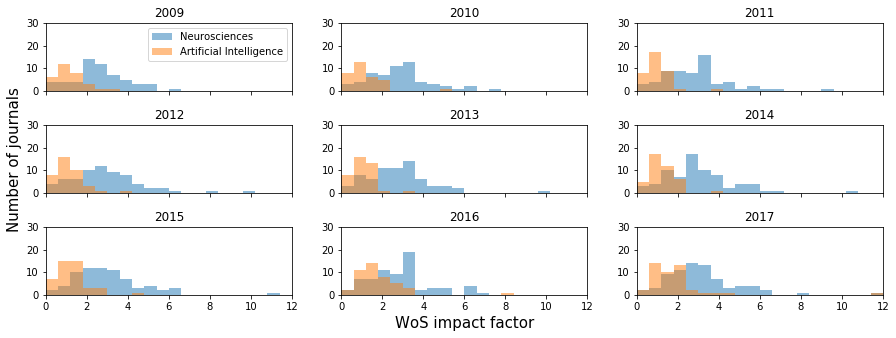

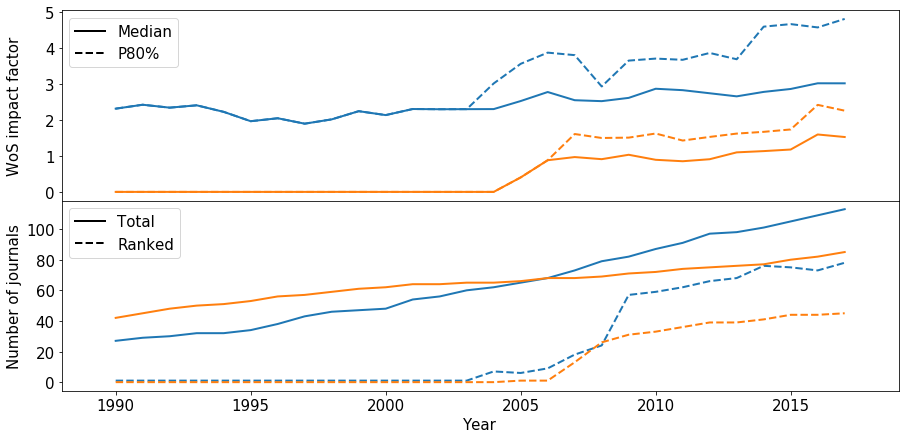

In [11]:
categoryname1 = 'Neurosciences'
categoryname2 = 'Artificial Intelligence'
max_journ = 30
max_if = 12
bins = 20

plt.figure( figsize=(15,5) )
plt.subplots_adjust( hspace=0.5 )
for i_y, year in enumerate(np.arange(2009,2018)):
    plt.subplot( 3,3,i_y+1 )
    
    #category 1
    distro = IF_WoS_props( categoryname1, year=year, complete_dist=True)
    plt.hist( distro, range=(0,max_if), bins=bins, label=categoryname1, alpha=0.5 )

    #category 2
    distro = IF_WoS_props( categoryname2, year=year, complete_dist=True)
    plt.hist( distro, range=(0,max_if), bins=bins, label=categoryname2, alpha=0.5)

    plt.title(year)
    plt.xlim(0,max_if)
    plt.ylim(0,max_journ)
    
    if i_y==0:
        plt.legend( loc='upper right' )
    if i_y<6:
        plt.xticks( np.arange(0,max_if+2,2), '' )
    if i_y==3:
        plt.ylabel( "Number of journals", fontsize=15 )
    if i_y==7:
        plt.xlabel( "WoS impact factor", fontsize=15 )
    
    
    
fig = plt.figure( figsize=(15,7) )
plt.subplots_adjust( hspace=0 )
plt.subplot( 2,1,1 )

#category 1
median = np.array(disciplines[medians_disc])[index_disc[categoryname1]]
p80 = np.array(disciplines[p80_disc])[index_disc[categoryname1]]
plt.plot( years_disc, median, lw=2, color='#1f77b4', ls='-' )
plt.plot( years_disc, p80, lw=2, color='#1f77b4', ls='--' )
#category 2
median = np.array(disciplines[medians_disc])[index_disc[categoryname2]]
p80 = np.array(disciplines[p80_disc])[index_disc[categoryname2]]
plt.plot( years_disc, median, lw=2, color='#ff7f0e', ls='-' )
plt.plot( years_disc, p80, lw=2, color='#ff7f0e', ls='--' )

plt.plot( [0,], [0,], lw=2, label='Median', color='black', ls='-' )
plt.plot( [0,], [0,], lw=2, label='P80%', color='black', ls='--' )
plt.xticks( np.arange(1990,2016,5), '' )
plt.xlim( (1988, 2019) )
plt.ylabel( "WoS impact factor", fontsize=15 )
plt.yticks( fontsize=15 )
plt.legend( loc='upper left', fontsize=15 )



plt.subplot( 2,1,2 )
#category 1
njournals = np.array(disciplines[journals_disc])[index_disc[categoryname1]]
nrjournals = np.array(disciplines[ranked_journals_disc])[index_disc[categoryname1]]
plt.plot( years_disc, njournals, lw=2, color='#1f77b4', ls='-' )
plt.plot( years_disc, nrjournals, lw=2, color='#1f77b4', ls='--' )
#category 2
njournals = np.array(disciplines[journals_disc])[index_disc[categoryname2]]
nrjournals = np.array(disciplines[ranked_journals_disc])[index_disc[categoryname2]]
plt.plot( years_disc, njournals, lw=2, color='#ff7f0e', ls='-' )
plt.plot( years_disc, nrjournals, lw=2, color='#ff7f0e', ls='--' )

plt.plot( [0,], [0,], lw=2, label='Total', color='black', ls='-' )
plt.plot( [0,], [0,], lw=2, label='Ranked', color='black', ls='--' )
plt.xlabel( "Year", fontsize=15 )
plt.xlim( (1988, 2019) )
plt.xticks( fontsize=15 )
plt.ylabel( "Number of journals", fontsize=15 )
plt.yticks( fontsize=15 )
fig.align_ylabels()
plt.legend( loc='upper left', fontsize=15 )

plt.show()

The growth of the impact factor $G_{\mathrm{WoS}}$ of each discipline is computed as:

$$ G_{\mathrm{WoS}} = \frac{\Delta \textrm{IF}_{\textrm{WoS}}}{\Delta t} = \frac{\textrm{IF}^{2017}_{\textrm{WoS}} - \textrm{IF}^{2010}_{\textrm{WoS}}}{2017-2010}. $$

2010 is taken as the reference year because as of this year, the WoS impact factor became standardized in most disciplines.

In [12]:
#disciplines['growth'] = np.sum((np.array(disciplines[medians_disc])[:,1:]-np.array(disciplines[medians_disc])[:,:-1])*(np.array(disciplines[medians_disc])[:,:-1]>0),axis=1)/(np.sum(np.array(disciplines[medians_disc])>0,axis=1)+1e-5)
disciplines['growth'] = (np.array(disciplines['median_2017']) - np.array(disciplines['median_2010']))/(2017.0-2010.)

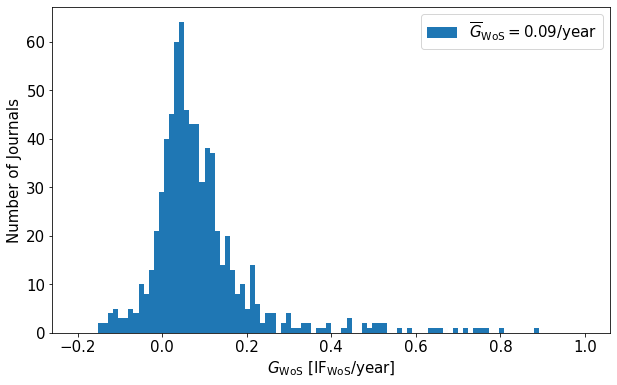

In [13]:
plt.figure( figsize = (10,6) )
plt.hist(disciplines['growth'][disciplines['growth']!=0], range=(-0.2,1), bins=100, 
         label='$\overline{G}_{\mathrm{WoS}} = %1.2f$/year'%
         (np.mean(disciplines['growth'][disciplines['growth']!=0])))
plt.xticks(fontsize=15)
plt.xlabel( "$G_{\mathrm{WoS}}$ [IF$_{\mathrm{WoS}}$/year]", fontsize=15 )
plt.yticks(fontsize=15)
plt.ylabel( "Number of Journals", fontsize=15 )
#plt.vlines()
plt.legend( loc='upper right', fontsize=15 )
plt.show()

On average, the WoS impact factor growth follows a normal distribution whose mean is about 0.09 per year for all disciplines. Interestingly, some disciplines exhibit negative growth.


## Case study: Neurosciences

Due to the large amount of available data, I will narrow the analysis by choosing only journals and authors affiliated to the discipline **Neurosciences**. As shown before, this is a growing discipline with about 110 active journals, of which 78 have a WoS impact factor in 2017.

In [14]:
main_discipline = 'Neurosciences'

In [15]:
#List of journals affiliated to main_discipline
mask_main_disc = journals_about.categoryname==main_discipline
idNum_journals = np.array(journals_about['idNum'].loc[mask_main_disc])
affiliated_journals = journals.iloc[idNum_journals].copy()

In [16]:
mask_2017 = journals_rating.dateCreated=='2017'
mask_journal_discipline = np.in1d( journals_rating.idNum[mask_2017], idNum_journals)
idNum_2017_journals_disc = np.array(journals_rating.idNum[mask_2017][mask_journal_discipline]).astype(int)
IF_2017_journals_disc = np.array(journals_rating.ratingValue[mask_2017][mask_journal_discipline]).astype(float)
year_journal = np.array(journals.startYear[idNum_2017_journals_disc]).astype(int)
open_journal = np.array(journals.isAccessibleForFree[idNum_2017_journals_disc])

A list of journals affiliated to Neurosciences is selected. The top 20% journals in 2017 are shown below:

In [17]:
pd.DataFrame(np.array([
    list(journals.name[idNum_2017_journals_disc[np.argsort(IF_2017_journals_disc)[::-1]]]), 
    IF_2017_journals_disc[np.argsort(IF_2017_journals_disc)[::-1]],
    year_journal[np.argsort(IF_2017_journals_disc)[::-1]],
    idNum_2017_journals_disc[np.argsort(IF_2017_journals_disc)[::-1]]]).T, 
    columns=['name', 'IF_WoS_2017', 'startYear', 'idNum'])[:15]

,name,IF_WoS_2017,startYear,idNum
0,Nature Reviews Neuroscience,32.635,2000,274
1,Nature Medicine,32.621,1995,1988
2,Nature Neuroscience,19.912,1998,2059
3,Acta Neuropathologica,15.872,1961,166
4,Molecular Psychiatry,11.64,1996,2017
5,Translational Stroke Research,8.266,2010,950
6,Neuropsychopharmacology,6.544,1987,1829
7,Molecular Neurodegeneration,6.426,2006,705
8,Translational Neurodegeneration,5.872,2012,1177
9,Molecular Autism,5.872,2010,1009


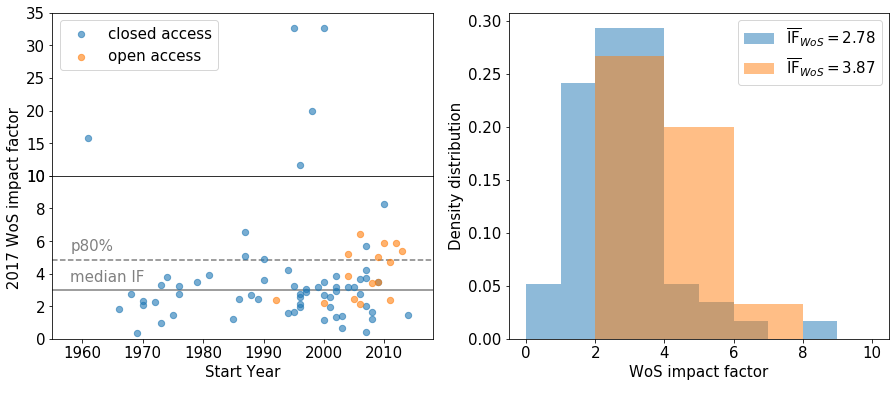

In [18]:
fig = plt.figure( figsize = (15,6) )
plt.subplots_adjust( hspace=0, wspace=0.5 )
gs = fig.add_gridspec(2, 4)
plt.subplot(gs[0, :2])
plt.scatter( year_journal[open_journal==False], IF_2017_journals_disc[open_journal==False], 
             color='#1f77b4', s=40, alpha=0.6, label='closed access' )
plt.scatter( year_journal[open_journal], IF_2017_journals_disc[open_journal], 
             color='#ff7f0e', s=40, alpha=0.6, label='open access' )
plt.xlim(1955, 2018)
plt.ylim(10,35)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', fontsize = 15)


plt.subplot(gs[1, :2])
plt.scatter( year_journal[open_journal==False], IF_2017_journals_disc[open_journal==False], 
             color='#1f77b4', s=40, alpha=0.6 )
plt.scatter( year_journal[open_journal], IF_2017_journals_disc[open_journal], 
             color='#ff7f0e', s=40, alpha=0.6 )
plt.hlines( disciplines[disciplines.categoryname==main_discipline].median_2017, 1955, 2020, 
            ls='-', color='gray', zorder=-1 )
plt.text( 1958, 3.5, 'median IF', fontsize=15, color='gray')
plt.hlines( disciplines[disciplines.categoryname==main_discipline].p80_2017, 1955, 2020, 
            ls='--', color='gray', zorder=-1 )
plt.text( 1958, 5.4, 'p80%', fontsize=15, color='gray')
plt.xlim(1955, 2018)
plt.ylim(0,10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel( 'Start Year', fontsize = 15 )
plt.ylabel( "                         2017 WoS impact factor", fontsize=15 )

plt.subplot(gs[0:, 2:])
plt.hist( IF_2017_journals_disc[open_journal==False],range=(0,10), 
          label = '$\overline{\mathrm{IF}}_{WoS} = %1.2f$'%(np.median(IF_2017_journals_disc[open_journal==False])), 
          bins=10, density=True, alpha=0.5 )
plt.hist( IF_2017_journals_disc[open_journal], range=(0,10), 
          label = '$\overline{\mathrm{IF}}_{WoS} = %1.2f$'%(np.median(IF_2017_journals_disc[open_journal])), 
          bins=5, density=True, alpha=0.5 )

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel( "WoS impact factor", fontsize=15 )
plt.ylabel( "Density distribution", fontsize=15 )

plt.legend(loc='upper right', fontsize = 15)
plt.show()


In the left panel, foundation year vs 2017 WoS impact factor of journals in Neurosciences. Colors indicate whether a journal is open or closed access. In the left panel, histogram of 2017 WoS impact factor for open and closed access journals.

It is interesting to note that the 5 top journals are very far apart from most of the journals in terms of the impact factor. This group corresponds to well establised journals that are well-known in this discipline. All of them are more than 20 years old. *Acta Neuropathologica* is the oldest one of this group, founded in 1961.

A second group of the top 20% journals has WoS impact factors of about 5, and is founded in the last 15 years. A very clear trend appears here in terms of the accessibility of the journal content. Most of the journals of this group are open access. In the left histogram, this trend is quantified, thereby yielding a median impact factor of 3.87 for open journals and 2.78 for those with paid content.

In order to design a growth strategy for journals with low or no impact factor, I will focus on the 2 top journals of the second described group, of which one is open access and the other has paid content. These journals will serve as models. The reasoning behind this is that these journals are rather modern and have growth within the [current scientific ecosystem](https://www.the-scientist.com/letter/the-scientific-ecosystem-58246). A good example of this is that none of the top journals of the first group are open access, as this is a rather recent concept in the publishing industry.

In [19]:
pd.DataFrame(np.array([
    list(journals.name[idNum_2017_journals_disc[np.argsort(IF_2017_journals_disc)[::-1]]]), 
    IF_2017_journals_disc[np.argsort(IF_2017_journals_disc)[::-1]],
    year_journal[np.argsort(IF_2017_journals_disc)[::-1]],
    idNum_2017_journals_disc[np.argsort(IF_2017_journals_disc)[::-1]]]).T, 
    columns=['name', 'IF_WoS_2017', 'startYear', 'idNum']).iloc[[5,7]]

,name,IF_WoS_2017,startYear,idNum
5,Translational Stroke Research,8.266,2010,950
7,Molecular Neurodegeneration,6.426,2006,705


- - -

# Authors, Articles and Grants

## Loading data for Neurosciences

In [20]:
recompute = False
if recompute:
    id_article = []
    file_number = []
    i_fail = 0
    for i_file in np.arange(0,10684):
        with open('./data/articles/articles_%d.jsonl'%i_file, 'r') as jsonl_file:
            for line in jsonl_file:
                try:
                    id_article.append(json.loads(line)['isPartOf'][0]['id'])
                    file_number.append(i_file)
                except:
                    i_fail+=1

    f = open('./data/articles/Files_Index.txt','w')
    for i_art in np.arange(0,len(id_article)):
        f.write('%s\t %d\n'%(id_article[i_art], file_number[i_art]))
    f.close()

    #Finding files in which articles of the selected journal are located
    idNum_article = np.array(list(map(index_journals.get, id_article)))
    mask_none_art = idNum_article!=None
    idNum_article = idNum_article[mask_none_art]
    mask_aff_art = np.in1d(idNum_article, idNum_journals )

    #Files to look in
    file_number_disc = np.unique(np.array(file_number)[mask_none_art][mask_aff_art])
    plt.savetxt( './data/articles/Files_Index_%s.txt'%main_discipline, file_number_disc, fmt='%d' )

In [21]:
file_number_disc = np.loadtxt('./data/articles/Files_Index_%s.txt'%main_discipline).astype(int)

In [22]:
recompute = False
if recompute:
    #Loading all relevant information from articles
    Nchunks = 13
    for i_chunk in np.arange(0,Nchunks):
        data_json = []
        i_fail = 0
        for i_file in file_number_disc[500*i_chunk:500*(i_chunk+1)]:
            with open('./data/articles/articles_%d.jsonl'%i_file, 'r') as jsonl_file:
                for line in jsonl_file:
                    try:
                        id_art_tmp = json.loads(line)['isPartOf'][0]['id']
                        if index_journals[id_art_tmp] in idNum_journals:
                            fields_art = ['author', 
                                          'id_journal', 
                                          'datePublished']
                            values_art = [json.loads(line)['author'], 
                                          index_journals[id_art_tmp], 
                                          int(json.loads(line)['datePublished'][:4]) ]
                            dict_article = dict(zip(fields_art, values_art))
                            data_json.append(dict_article)
                    except:
                        i_fail+=1    
        affiliated_articles = pd.DataFrame(data_json)
        affiliated_articles.to_pickle('./data/articles/articles_%d_%s.pkl'%(i_chunk, main_discipline))

In [95]:
recompute = False
if recompute:
    #Unifying database of authors and articles
    Nchunks = 13
    for i_chunk in np.arange(0,Nchunks):
        data_tmp = pd.read_pickle('./data/articles/articles_%d_%s.pkl'%(i_chunk, main_discipline))
        sizes_tmp = [ len(data_tmp.author[i]) for i in np.arange(0,len(data_tmp))]

        if i_chunk==0:
            affiliated_articles = pd.DataFrame(np.array([data_tmp['datePublished'], data_tmp['id_journal']]).T)
            affiliated_articles.columns = ['datePublished', 'id_journal']

            affiliates = pd.DataFrame(
                          np.array([np.array(pd.DataFrame(list(itertools.chain.from_iterable(data_tmp.author))).id.copy()),
                                    np.repeat( data_tmp['datePublished'], sizes_tmp ),
                                    np.repeat( data_tmp['id_journal'], sizes_tmp ),
                                    np.repeat( np.arange( 0, len(data_tmp) ), sizes_tmp )]).T)
            affiliates.columns = ['author', 'datePublished', 'id_journal', 'id_article']
            #Filtering non registered authors
            affiliates = affiliates[affiliates.author.isnull()==False]
        else:
            affiliated_articles_tmp = pd.DataFrame(np.array([data_tmp['datePublished'], data_tmp['id_journal']]).T)
            affiliated_articles_tmp.columns = ['datePublished', 'id_journal']

            affiliates_tmp = pd.DataFrame(
                          np.array([np.array(pd.DataFrame(list(itertools.chain.from_iterable(data_tmp.author))).id.copy()),
                                    np.repeat( data_tmp['datePublished'], sizes_tmp ),
                                    np.repeat( data_tmp['id_journal'], sizes_tmp ),
                                    np.repeat( np.arange( 0, len(data_tmp) )+len(affiliated_articles), sizes_tmp )]).T)
            affiliates_tmp.columns = ['author', 'datePublished', 'id_journal', 'id_article']
            #Filtering non registered authors
            affiliates_tmp = affiliates_tmp[affiliates_tmp.author.isnull()==False]

            affiliated_articles = affiliated_articles.append(affiliated_articles_tmp, ignore_index=True)
            affiliates = affiliates.append(affiliates_tmp, ignore_index=True)


    #Computing wheather an article was publish in a high-impact factor journal (above p80%) at datePublished.
    top_journal = []
    for i_art in np.arange(len(affiliated_articles)):
        year_tmp = np.min((affiliated_articles.datePublished[i_art],2017))
        mask_idNum_tmp = journals_rating.idNum == affiliated_articles.id_journal[i_art]
        years_tmp = np.array(journals_rating.dateCreated[mask_idNum_tmp]).astype(float)
        ratings_tmp = np.array(journals_rating.ratingValue[mask_idNum_tmp]).astype(float)
        try:
            mask_year_tmp = years_tmp==year_tmp
            if sum(mask_year_tmp)==0:
                mask_year_tmp = [np.argsort( years_tmp[np.isnan(years_tmp)==False] )[0,]]
            top_journal.append( (ratings_tmp[mask_year_tmp] >= float(disciplines[disciplines.categoryname==main_discipline].p80_2017) )[0])
        except:
            top_journal.append(False)    

    affiliated_articles['top_journal'] = top_journal
            
    affiliates.to_pickle('./data/articles/authors_%s.pkl'%(main_discipline))
    affiliated_articles.to_pickle('./data/articles/articles_all_%s.pkl'%(main_discipline))
affiliates = pd.read_pickle('./data/articles/authors_%s.pkl'%(main_discipline))
affiliated_articles = pd.read_pickle('./data/articles/articles_all_%s.pkl'%(main_discipline))

In [25]:
recompute = False
if recompute:
    #Loading grants
    for i_grant in np.arange(0,283):
        print(i_grant)
        with open('./data/grants/grants_%d.jsonl'%i_grant, 'r') as jsonl_file:
            for line in jsonl_file:
                try:
                    mask_person = pd.DataFrame(json.loads(line)['recipient']).type=='Person'
                    people_grant = np.array(pd.DataFrame(json.loads(line)['recipient'])[mask_person].id)
                    size_people = len(people_grant)
                    if i_grant==0:
                        grants = pd.DataFrame(
                                      np.array([people_grant,
                                                np.repeat( int(json.loads(line)['startDate'][:4]), size_people ),
                                                np.repeat( float(json.loads(line)['amount']['value']), size_people ),
                                                np.repeat( json.loads(line)['amount']['currency'], size_people )]).T)

                        grants.columns = ['author', 'startDate', 'amount', 'currency']
                    else:
                        grants_tmp = pd.DataFrame(
                                      np.array([people_grant,
                                                np.repeat( int(json.loads(line)['startDate'][:4]), size_people ),
                                                np.repeat( float(json.loads(line)['amount']['value']), size_people ),
                                                np.repeat( json.loads(line)['amount']['currency'], size_people )]).T)

                        grants_tmp.columns = ['author', 'startDate', 'amount', 'currency']

                        grants = grants.append(grants_tmp, ignore_index=True)
                except:
                    None
    grants.to_pickle( './data/grants/grants_all.pkl' )
grants = pd.read_pickle( './data/grants/grants_all.pkl' )

In [68]:
#Converting all currencies to USD
currencies = np.unique(grants.currency)
values_USD = [ 0.68, 0.77, 1.01, 0.14, 0.044, 1.11, 1.29, 0.13, 0.15, 0.0034, 0.28, 0.008, 0.11, 0.64, 0.26, 0.10, 1]
conversion_factors = dict(zip(currencies, values_USD))
pd.DataFrame( np.array( [currencies, values_USD] ).T, columns=['currency', 'factor_USD'] )

,currency,factor_USD
0,AUD,0.68
1,CAD,0.77
2,CHF,1.01
3,CNY,0.14
4,CZK,0.044
5,EUR,1.11
6,GBP,1.29
7,HKD,0.13
8,HRK,0.15
9,HUF,0.0034


In [81]:
#Converting all values to USD
amount_USD = np.zeros(len(grants))
#Creating new field with USD value for grant amount
for currency in currencies:
    mask_currency = grants.currency==currency
    amount_USD[mask_currency] = np.array(grants.amount.copy()[mask_currency])*conversion_factors[currency]
grants['amount_USD'] = amount_USD

In [100]:

    print(i_year, year)

0 2005
1 2006
2 2007
3 2008
4 2009
5 2010
6 2011
7 2012
8 2013
9 2014
10 2015
11 2016
12 2017


In [ ]:
#Creating database of authors in main discipline
#authors_main_disc = np.unique(affiliates.author)
total_articles = np.zeros( (13, len(authors_main_disc)) )
total_top_articles = np.zeros( (13, len(authors_main_disc)) )
total_grants = np.zeros( (13, len(authors_main_disc)) )

for i_author, author in enumerate(authors_main_disc):
    for i_year, year in enumerate(np.arange(2005, 2018)):
        
        
    

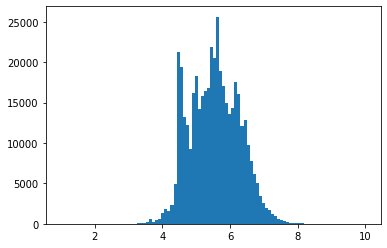

In [94]:
plt.hist(np.log10(grants['amount_USD']+1e-5), range=(1,10), bins=100)
plt.show()

In [52]:
for i in np.arange(100):
    if sum(grants.author == authors_main_disc[i])>0:
        break
print(i)

7


In [96]:
authors_main_disc = np.unique(affiliates.author)

In [44]:
np.in1d(grants.author, authors_main_disc)

KeyboardInterrupt: 

In [31]:
np.in1d( ['a','b','c','d'], ['a', 'b'] )

array([ True,  True, False, False])

(array([3.00000e+00, 4.00000e+00, 1.19400e+03, 9.68300e+03, 1.41360e+04,
        1.72220e+04, 2.63130e+04, 7.07050e+04, 1.76455e+05, 1.46905e+05]),
 array([1957.0, 1963.1, 1969.2, 1975.3, 1981.4, 1987.5, 1993.6, 1999.7,
        2005.8, 2011.9, 2018.0], dtype=object),
 <a list of 10 Patch objects>)

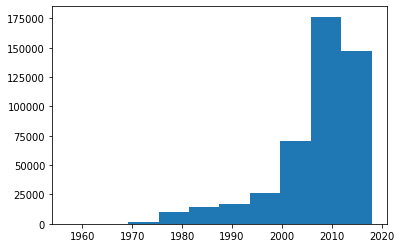

In [30]:
plt.hist(grants.startDate)

In [393]:
json.loads(line)

{'@context': 'https://springernature.github.io/scigraph/jsonld/sgcontext.json',
 'type': 'MonetaryGrant',
 'id': 'sg:grant.6810536',
 'sdDatePublished': '2019-03-07T11:15',
 'sdLicense': 'https://scigraph.springernature.com/explorer/license/',
 'sdPublisher': {'type': 'Organization',
  'name': 'Springer Nature - SN SciGraph project'},
 'sdDataset': 'grants',
 'sdSource': 's3://com.uberresearch.data.processor/core_data/20181219_192338/projects/base/aacr_projects.xml.gz',
 'amount': {'type': 'MonetaryAmount', 'currency': 'USD', 'value': '110000'},
 'name': 'Overcoming acquired drug resistance in ALK fusion-positive lung cancers',
 'inLanguage': ['en'],
 'identifier': [{'type': 'PropertyValue',
   'name': 'dimensions_id',
   'value': ['6810536']},
  {'type': 'PropertyValue', 'name': 'aacr_id', 'value': ['17-40-12-DARD']}],
 'funder': {'type': 'Organization',
  'id': 'https://www.grid.ac/institutes/grid.280840.6'},
 'sameAs': ['https://app.dimensions.ai/details/grant/grant.6810536'],
 'des

In [386]:
len(np.unique(affiliates.author))

426260

In [387]:
affiliated_articles.top_journal

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27         True
28         True
29         True
          ...  
441569     True
441570     True
441571     True
441572     True
441573    False
441574     True
441575     True
441576     True
441577    False
441578     True
441579    False
441580     True
441581     True
441582     True
441583     True
441584    False
441585    False
441586     True
441587     True
441588     True
441589     True
441590     True
441591     True
441592     True
441593     True
441594     True
441595    False
441596    False
441597     True
441598    False
Name: top_journal, Lengt

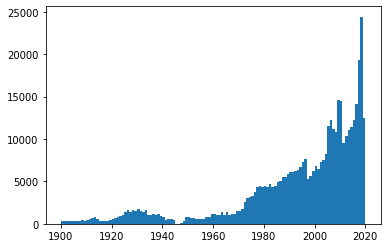

In [58]:
plt.hist(affiliated_articles.datePublished, bins=120, cumulative=False, range=(1900,2020))
plt.show()

## Loading authors

In [860]:
f = open('./data/persons/Authors.txt','')
for i_author in np.arange(0,2242):
    with open('./data/persons/persons_%d.jsonl'%i_author, 'r') as jsonl_file:
        for line in jsonl_file:
            f.write('%s\n'%json.loads(line)['id'])
f.close()

In [862]:
authors = np.genfromtxt('./data/persons/Authors.txt', dtype='str')

## Loading grants

USD
USD
USD
USD
USD
USD
USD
USD
USD
USD
USD
USD
USD
USD
USD
USD
USD
USD
USD
USD


{'@context': 'https://springernature.github.io/scigraph/jsonld/sgcontext.json',
 'type': 'MonetaryGrant',
 'id': 'sg:grant.6810536',
 'sdDatePublished': '2019-03-07T11:15',
 'sdLicense': 'https://scigraph.springernature.com/explorer/license/',
 'sdPublisher': {'type': 'Organization',
  'name': 'Springer Nature - SN SciGraph project'},
 'sdDataset': 'grants',
 'sdSource': 's3://com.uberresearch.data.processor/core_data/20181219_192338/projects/base/aacr_projects.xml.gz',
 'amount': {'type': 'MonetaryAmount', 'currency': 'USD', 'value': '110000'},
 'name': 'Overcoming acquired drug resistance in ALK fusion-positive lung cancers',
 'inLanguage': ['en'],
 'identifier': [{'type': 'PropertyValue',
   'name': 'dimensions_id',
   'value': ['6810536']},
  {'type': 'PropertyValue', 'name': 'aacr_id', 'value': ['17-40-12-DARD']}],
 'funder': {'type': 'Organization',
  'id': 'https://www.grid.ac/institutes/grid.280840.6'},
 'sameAs': ['https://app.dimensions.ai/details/grant/grant.6810536'],
 'des

- - -

# Fields

Although the categorization of journals in different disciplines is useful to identify similar (competing) journals, many disciplines are very narrow and specific. As a consequence, some disciplines have only a few journals (only 1 in some cases), a situation that is not ideal for robust statistical analysis.

In order to mitigate this problem, I define a more general category called *Field*, which is associated to every discipline. The Field of a discipline consists of all the associated disciplines that are link by at least two journals (*about.name*). Disciplines linked by only one journal are not considered to be strongly related. (In technical terms, this is called a [Collaboration graph](https://en.wikipedia.org/wiki/Collaboration_graph).)

In the following diagram, I illustrate how a Field is defined.
![](https://raw.githubusercontent.com/sbustamante/scigraph_project/master/figures/Graph_Fields.png)

*Note that the threshold in the number of linking journals can be changed and consists of a free parameter.*
 



In [719]:
#Linking Matrix that contains the connections (journals) between the disciplines.
graph_links = np.zeros((n_disc,n_disc))

#Filling matrix
for i_cat, categoryname in enumerate(disciplines.categoryname):
    mask_cat_tmp = journals_about['categoryname'] == categoryname
    id_tmp = np.array(journals_about['idNum'][mask_cat_tmp].astype(int))
    mask_field_tmp = np.in1d( np.array(journals_about['idNum'].astype(int)), id_tmp )
    mask_no_tmp = journals_about['categoryname'][mask_field_tmp].values != categoryname
    if np.sum(mask_no_tmp)!=0:
        non_repeat_journals_tmp = journals_about['categoryname'][mask_field_tmp][mask_no_tmp]
        mask_nan_tmp = non_repeat_journals_tmp.isnull()==False
        indices_tmp = list(map(index_disc.get, 
                               non_repeat_journals_tmp[mask_nan_tmp]))
        counter = collections.Counter(indices_tmp)
        graph_links[i_cat,list(counter.keys())] = list(counter.values())

Top disciplines and corresponding size of their fields

In [823]:
#Creating Table with fields
n_link_journal = 1
mask_fields_order = np.argsort(np.sum(graph_links>=n_link_journal,axis=1))[::-1]

fields_counts = pd.DataFrame()
fields_counts['categoryname']=list(disciplines.categoryname)
fields_counts['linked_categories_1']=np.sum(graph_links>=1,axis=1)
fields_counts['linked_categories_2']=np.sum(graph_links>=2,axis=1)
fields_counts['linked_categories_5']=np.sum(graph_links>=5,axis=1)
fields_counts['linked_categories_10']=np.sum(graph_links>=10,axis=1)
fields_counts.iloc[mask_fields_order][:50]

,categoryname,linked_categories_1,linked_categories_2,linked_categories_5,linked_categories_10
769,"Medicine/Public Health, general",152,84,29,5
517,"Life Sciences, general",131,71,23,8
757,Public Health,130,60,22,9
192,"Biochemistry, general",117,60,25,9
433,"Biomedicine, general",113,60,23,11
801,Artificial Intelligence,110,60,15,3
308,Neurosciences,104,57,20,7
79,"Social Sciences, general",104,41,6,2
438,Cell Biology,97,59,26,13
94,Internal Medicine,97,68,34,14


- - -